In [9]:
import os
import sys
sys.path.append("/home/ubuntu/mlab/days/w3d3/rl_env/lib/python3.8/site-packages")
sys.path.append("/home/ubuntu/mlab/days/w3d3/rl_env/lib/python3.9/site-packages")

In [2]:
import gym
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
from IPython.display import Video
from video_recorder import VideoRecorder
import einops
import torch
from torch import nn
import numpy as np

import rl_tests
import days.atari_wrappers as atari_wrappers

from collections import deque
from dataclasses import dataclass
import random
import tqdm
import typing

In [14]:
%load_ext line_profiler

ModuleNotFoundError: No module named 'line_profiler'

In [ ]:
devices = [f'cuda:{i}' for i in [0, 1, 2, 3]]

In [ ]:
env_name = "CartPole-v1"
# env_name = 'MountainCarContinuous-v0'
record = True
video_name = "test_0"

env = gym.make(env_name)
state = env.reset()
done = False
total_reward = 0
video_recorder = VideoRecorder(env, base_path=f'videos/{video_name}')

def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.axis('off')
    display.clear_output(wait=True)
    display.display(plt.gcf())

states = 0
while not done:
    states += 1
    if record:
        video_recorder.capture_frame()
    else:  
        show_state(env)
    state, reward, done, _ = env.step(env.action_space.sample()) # Take a random action
    total_reward += reward

print(f"total reward: {total_reward}")
if record:
    video_recorder.close()

total reward: 17.0


In [ ]:
# Display a saved video 
Video("videos/test_0.mp4")

In [ ]:
class MLP(nn.Module):
    def __init__(self, in_size : int, hidden_size : int, out_size : int) -> None:
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, out_size),
        )

    # obs: Tensor[..., obs_shape]) -> Tensor[..., num_actions]
    def forward(self, obs):
        return self.layers(obs)
    
rl_tests.test_q_net(MLP)

test_q_net MATCH!!!!!!!!
 SHAPE (16, 58) MEAN: 0.004251 STD: 0.09947 VALS [0.07635 -0.04347 -0.01919 0.01093 0.02231 -0.04737 0.1792 -0.1415 0.1615 0.01988...]


In [ ]:
cartpole_env = gym.make("CartPole-v1")
cartpole_eval_env = gym.make("CartPole-v1")

In [ ]:
def make_choice(
    env: gym.Env, eps: float, net: nn.Module, obs, device: str
) -> int:
    if random.random() < eps:
        return env.action_space.sample()
    action_scores = net(torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0))
    best_action = action_scores.argmax(dim=-1)
    return best_action.item()

In [ ]:
def evaluate(model: nn.Module, env: gym.Env, eps: float, device: str, video_name = None) -> float:
    # env.reset() returns an initial observation, so make sure to do this at the beginning.
    # Feel free to modify the above function by adding arguments like epsilon : float, device : string, save_video : bool.
    # This is an eval function; make sure you’re not storing gradients
    # Note that env.step takes an action (an int between 0 and env.action_space.n - 1, inclusive) and returns:
    #   state: Tensor  The next observation
    #   reward: float  The reward gained during the timestep
    #   done: bool  Whether or not the episode is over
    #   info: dict  extra information like number of lives remaining
    #   You’ll need to handle the ‘done’ output by exiting the loop when the episode ends.
    
    is_recording = video_name is not None
    if is_recording:
        video_recorder = VideoRecorder(env, base_path=f'videos/{video_name}')  
    
    state = env.reset()
    if is_recording:
        video_recorder.capture_frame()
    done = False
    total_reward = 0
    states = 0
    
    model.to(device)
    model.eval()
    
    with torch.no_grad():
        while not done:
            states += 1
            action = make_choice(env=env, eps=eps, net=model, obs=state, device=device)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if is_recording:
                video_recorder.capture_frame()
            
    if is_recording:
        video_recorder.close()

    return total_reward

In [ ]:
(in_size,) = cartpole_env.observation_space.shape
cartpole_q_net = MLP(in_size=in_size, hidden_size=64, out_size=cartpole_env.action_space.n)
evaluate(model=cartpole_q_net, env=cartpole_env, eps=0.05, device=devices[0], video_name="cartpole-eval")

11.0

In [ ]:
Video(f"videos/cartpole-eval.mp4")

In [ ]:
class StubEnv(gym.Env):
    '''idk'''
    def __init__(self):
        self.action_space = gym.Discrete(2)
        self.observation_space = gym.Discrete(1)
        self.reward_range = (0, 1)
        
    def step(self):
        pass
    
    def reset(self):
        pass
    
    def seed(self):
        pass

In [ ]:
@dataclass
class TrainConfig:
    train_freq: int
    eval_freq: int
    batch_size: int
    # decay eps from eps_start to eps_end over the first eps_decay_steps steps
    eps_start: float
    eps_end: float
    eps_decay_steps: int
    discount_rate: float
    max_experiences: int
    lr: float
    n_steps: int

@dataclass
class Experience:
    state: any # something from the observation space
    action: any # something from the action space
    state_after: any # something from the observation space
    reward: int
    done: bool
    
def reward_from_experience(experience, model, discount_rate, device):
    if experience.done:
        return experience.reward
    else:
        with torch.no_grad():
            predicted_values_of_actions = model(torch.tensor(experience.state_after, dtype=torch.float32, device=device))
        future_reward = torch.max(predicted_values_of_actions)
        return experience.reward + discount_rate * future_reward
    
def batched_reward_from_experience(samples, model, discount_rate, device):
    with torch.no_grad():
        state_afters = torch.tensor(np.stack([
                sample.state_after for sample in samples
            ], axis=0), dtype=torch.float32, device=device)
        predicted_values_of_actions = model(state_afters)
    future_rewards = predicted_values_of_actions.max(dim=1).values
    reward = torch.tensor([sample.reward for sample in samples], dtype=torch.float32, device=device)
    not_done = torch.tensor([not sample.done for sample in samples], dtype=torch.bool, device=device)
    reward[not_done] += discount_rate * future_rewards[not_done]
    return reward        

def training_loop(
        model: nn.Module, 
        train_env: gym.Env,
        eval_env: gym.Env,
        config: TrainConfig,
        device: str,
):
    model.train()
    loss_fn = nn.MSELoss()
    losses = []
    evaluations = []
    opt = torch.optim.Adam(model.parameters(), lr=config.lr)
    experiences = deque(maxlen=config.max_experiences)
    state = train_env.reset()
    print_freq = config.n_steps // 20
    for action_idx in range(config.n_steps):
        if action_idx <= config.eps_decay_steps:
            eps = config.eps_start + (config.eps_end - config.eps_start) * action_idx / config.eps_decay_steps
        
        action = make_choice(env=train_env, eps=eps, net=model, obs=state, device=device)
        state_after, reward, done, _ = train_env.step(action)
        experiences.append(Experience(state, action, state_after, reward, done))
        state = state_after
        if done:
            obs = train_env.reset()
        if action_idx > 0 and action_idx % config.train_freq == 0:  # train the model
            samples = random.choices(experiences, k=config.batch_size)
            input_batch = torch.tensor(np.array([sample.state for sample in samples]), dtype=torch.float32, device=device)
            opt.zero_grad()
            rewards_predicted = model(input_batch)
            assert rewards_predicted.shape == (config.batch_size, train_env.action_space.n)
            target_indices = torch.tensor([sample.action for sample in samples], device=device).unsqueeze(1)
            assert target_indices.shape == (config.batch_size, 1)
            target_batch = torch.gather(rewards_predicted, dim=1, index=target_indices).squeeze(1)
            assert target_batch.shape == (config.batch_size,), target_batch.shape
            rewards_from_experience = batched_reward_from_experience(samples, model, config.discount_rate, device)
            assert rewards_from_experience.shape == (config.batch_size,)
            loss = loss_fn(target_batch, rewards_from_experience)
            losses.append((action_idx, loss.item()))
            loss.backward()
            opt.step()
            if (action_idx // config.train_freq) % config.eval_freq == 0:
                reward = evaluate(model=model, env=eval_env, eps=0, device=device)
                evaluations.append((action_idx, reward))
                model.train()
        if action_idx % print_freq == 0:
            print(f"{action_idx=}")
                
    plt.scatter([i for i, _ in losses], [loss for _, loss in losses])
    plt.show()
    plt.scatter([i for i, _ in evaluations], [r for _, r in evaluations])
    plt.show()

action_idx=0
action_idx=1500
action_idx=3000
action_idx=4500
action_idx=6000
action_idx=7500
action_idx=9000
action_idx=10500
action_idx=12000
action_idx=13500
action_idx=15000
action_idx=16500
action_idx=18000
action_idx=19500
action_idx=21000
action_idx=22500
action_idx=24000
action_idx=25500
action_idx=27000
action_idx=28500


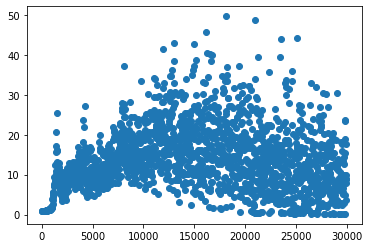

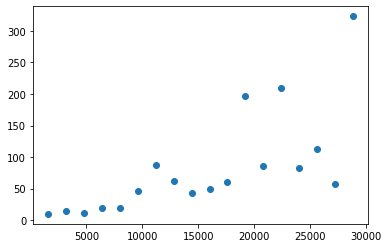

In [ ]:
(in_size,) = cartpole_env.observation_space.shape
device = devices[0]
cartpole_q_net = MLP(in_size=in_size, hidden_size=64, out_size=cartpole_env.action_space.n).to(device)
training_config = TrainConfig(
    train_freq=16,
    eval_freq=100,
    batch_size=128,
    eps_start=0.1,
    eps_end=0.05,
    eps_decay_steps=20000,
    discount_rate=0.98,
    max_experiences=10000,
    lr=1e-3,
    n_steps=30000,
)
training_loop(model=cartpole_q_net, train_env=cartpole_env, eval_env=cartpole_eval_env, config=training_config, device=device)

In [ ]:
evaluate(model=cartpole_q_net, env=cartpole_eval_env, eps=0, device=devices[0], video_name="trained-cartpole")
Video(f"videos/trained-cartpole.mp4")

action_idx=0
action_idx=2000
action_idx=4000
action_idx=6000
action_idx=8000
action_idx=10000
action_idx=12000
action_idx=14000
action_idx=16000
action_idx=18000
action_idx=20000
action_idx=22000
action_idx=24000
action_idx=26000
action_idx=28000
action_idx=30000
action_idx=32000
action_idx=34000
action_idx=36000
action_idx=38000


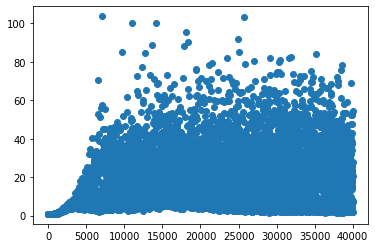

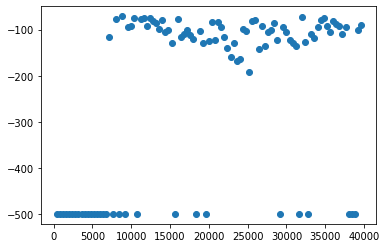

In [ ]:
acrobot_env = gym.make("Acrobot-v1") 
acrobot_eval_env = gym.make("Acrobot-v1")

(in_size,) = acrobot_env.observation_space.shape
device = devices[0]
acrobot_q_net = MLP(in_size=in_size, hidden_size=64, out_size=acrobot_env.action_space.n).to(device)
n_steps = 40000
acrobot_config = TrainConfig(
    train_freq=4,
    eval_freq=100,
    batch_size=128,
    eps_start=1,
    eps_end=0.1,
    eps_decay_steps=n_steps // 10,
    discount_rate=0.99,
    max_experiences=10000,
    lr=1e-4,
    n_steps=n_steps,
)
training_loop(
    model=acrobot_q_net, 
    train_env=acrobot_env, 
    eval_env=acrobot_eval_env, 
    config=acrobot_config, 
    device=device
)

In [ ]:
evaluate(model=acrobot_q_net, env=acrobot_eval_env, eps=0, device=devices[0], video_name="trained-acrobot")
Video(f"videos/trained-acrobot.mp4")

In [ ]:
breakout_train_env = atari_wrappers.AtariWrapper(gym.make("BreakoutNoFrameskip-v0"))
breakout_eval_env = atari_wrappers.AtariWrapper(gym.make("BreakoutNoFrameskip-v0"))

In [ ]:
(height, width, obs_n_channels) = breakout_train_env.observation_space.shape

class Rearrange(nn.Module):
    def __init__(self, rearrangement):
        super().__init__()
        self.rearrangement = rearrangement
        
    def forward(self, x):
        return einops.rearrange(x, self.rearrangement)

# obs_n_channels needs a value
breakout_q_net = nn.Sequential(
    Rearrange('b h w c -> b c h w'),
    nn.Conv2d(obs_n_channels, 32, 8, stride=4),
    nn.ReLU(),
    nn.Conv2d(32, 64, 4, stride=2),
    nn.ReLU(),
    nn.Conv2d(64, 64, 3, stride=1),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(3136, breakout_train_env.action_space.n),
).to(device)

In [ ]:
n_steps=2000
breakout_config = TrainConfig(
    train_freq=4,
    eval_freq=n_steps // 100,
    batch_size=32,
    eps_start=1,
    eps_end=0.01,
    eps_decay_steps=n_steps,
    discount_rate=0.99,
    max_experiences=100000,
    lr=3e-5,
    n_steps=n_steps,
)

In [ ]:
training_loop(
    model=breakout_q_net, 
    train_env=breakout_train_env, 
    eval_env=breakout_eval_env, 
    config=breakout_config,
    device=device
)

In [ ]:
import line_profiler
%load_ext line_profiler

ModuleNotFoundError: No module named 'line_profiler'

In [ ]:
%lprun -f training_loop training_loop(model=breakout_q_net, train_env=breakout_train_env, eval_env=breakout_eval_env, config=breakout_config,device=device)

ModuleNotFoundError: No module named 'line_profiler'

In [ ]:
evaluate(model=breakout_q_net, env=breakout_eval_env, eps=0, device=devices[0], video_name="trained-breakout")
Video(f"videos/trained-breakout.mp4")